We present a Fluxonium - Transmon - Fluxonium system with the purpose of using the middle transmon to facilitate parity checks and gates between the fluxoniums without the need for non-local interactions. First, we construct and analyze and analyze cross resonance CNOT gates with each fluxonium as the control and the transmon as the target. When applied sequentially and phase corrected with single qubit rotations, these CNOT gates can effectively produce a parity check which ideally leaves the two fluxonium states undisturbed while populating the transmon with their combined parity. We also demonstrate a scheme in which the two gates can be applied simultaneously for a faster and higher fidelity gate. Further, circuit parameter regimes like sample A in which w_d is close for CX1 and CX2 allow for a simplified scheme using pulses at a single frequency for less physical overhead at the cost of marginally worse fidelity.

Alongside parity checks, the transmon in this system can be used to facilitate gates across the two fluxoniums without the need for non-local interactions. To demonstrate this, we simulate an effective CNOT gate between the two fluxoniums by initializing the transmon to |1> and using a combination of CX1, CX2, and individual hadamards.

In [1]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt

from matplotlib.colors import LogNorm

### System Definition (Fl1 - Tr - Fl2), Sample A

In [ ]:
k = 120
trunc = 6
Fl1 = scq.Fluxonium(EJ=4.0, EC=1.41, EL=0.90, flux=0.5, cutoff=k, truncated_dim=trunc)
Fl2 = scq.Fluxonium(EJ=4.05, EC=1.41, EL=0.90, flux=0.5, cutoff=k, truncated_dim=trunc)
Tr = scq.Transmon(EJ=18, EC=0.25, ng=0, ncut=k, truncated_dim=trunc)

J1T = 0.031
J2T = 0.030
J12 = 0.0003

full_system = scq.HilbertSpace([Fl1, Tr, Fl2])
full_system.add_interaction(g = J1T, op1 = (Fl1.n_operator(), Fl1), op2 = (Tr.n_operator(), Tr))
full_system.add_interaction(g = J2T, op1 = (Fl2.n_operator(), Fl2), op2 = (Tr.n_operator(), Tr))
full_system.add_interaction(g = J12, op1 = (Fl1.n_operator(), Fl1), op2 = (Fl2.n_operator(), Fl2))
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2*np.pi*full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1,Tr,Fl2])
n_Fl2_full = scq.identity_wrap(Fl2.n_operator(), Fl2, [Fl1,Tr,Fl2])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1,Tr,Fl2])

a_Fl1_full = scq.identity_wrap(qt.destroy(trunc), Fl1, [Fl1,Tr,Fl2])
a_Fl2_full = scq.identity_wrap(qt.destroy(trunc), Fl2, [Fl1,Tr,Fl2])
a_Tr_full = scq.identity_wrap(qt.destroy(trunc), Tr, [Fl1,Tr,Fl2])

adag_Fl1_full = scq.identity_wrap(qt.create(trunc), Fl1, [Fl1,Tr,Fl2])
adag_Fl2_full = scq.identity_wrap(qt.create(trunc), Fl2, [Fl1,Tr,Fl2])
adag_Tr_full = scq.identity_wrap(qt.create(trunc), Tr, [Fl1,Tr,Fl2])

### Labeling States

In [ ]:
def get_dressed_epairs(evals, ekets):
    
    dressed_epairs = np.empty((5, 5, 5), dtype=object)
    
    for i in range(4):
        for j in range(4):
            for k in range(4):
                index = full_system.dressed_index((i,j,k))
                dressed_epairs[i,j,k] = (evals[index], ekets[index])
    return dressed_epairs
                
dressed_epairs = get_dressed_epairs(evals, ekets)

### Fl1-TR CNOT Gate

This section defines and evaluates an optimized CX gate between the left Fluxonium (control) and the Transmon (target)

In [4]:
eta = (np.abs(n_Fl1_full.matrix_element(dressed_epairs[0,0,0][1], dressed_epairs[0,1,0][1])      
        /n_Tr_full.matrix_element(dressed_epairs[0,0,0][1], dressed_epairs[0,1,0][1])))
t_g = 50
t_r = 5
t_list = np.linspace(0, t_g, 1000)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 
          'lime', 'teal', 'navy', 'maroon', 'olive', 'gold', 'cyan', 'magenta', 
          'gray', 'salmon', 'darkgreen', 'darkblue', 'turquoise']

U_id = 0
U_id += dressed_epairs[0,0,0][1]*dressed_epairs[0,0,0][1].dag()
U_id += dressed_epairs[0,1,0][1]*dressed_epairs[0,1,0][1].dag()
U_id += dressed_epairs[1,1,0][1]*dressed_epairs[1,0,0][1].dag()
U_id += dressed_epairs[1,0,0][1]*dressed_epairs[1,1,0][1].dag()
U_id += dressed_epairs[0,0,1][1]*dressed_epairs[0,0,1][1].dag()
U_id += dressed_epairs[0,1,1][1]*dressed_epairs[0,1,1][1].dag()
U_id += dressed_epairs[1,1,1][1]*dressed_epairs[1,0,1][1].dag()
U_id += dressed_epairs[1,0,1][1]*dressed_epairs[1,1,1][1].dag()


def prob_lists_1(psi):
    
    p_lists = [[] for _ in range(16)]  # Initialize a list of lists

    p_lists = [[] for _ in range(16)]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create 2x2 subplots
    axes = axes.flatten()  # Flatten the axes array for easier indexing




    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(16):
            overlap = np.abs(psi_t.overlap(dressed_epairs[i//8, (i//4)%2, i%2][1]))**2
            #if overlap > 1e-3:  # Check if the value exceeds the threshold
            p_lists[i].append(overlap)

    # # Assuming 'colors' is defined elsewhere with at least 24 colors
    # for i in range(16):
    #     if any(p > 1e-3 for p in p_lists[i]):  # Check if any value is above 1e-3
    #         ax_index = i % 4  # Determine the subplot index (0 to 3)
    #         label = "|" + str(i // 8) + str((i % 8) // 4) + str((i % 4) // 2) + ">"
    #         axes[ax_index].semilogy(t_list, p_lists[i], label=label, color=colors[i])
    #         axes[ax_index].set_ylim(1e-3, 1.9)  # Set ylim to start at 1e-3
    #         axes[ax_index].legend()
        


    # plt.show()
    return p_lists  # Return the list of lists
def prob_lists(psi):
    p_lists = [[] for _ in range(16)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(16):
            idx1 = i // 8
            idx2 = (i % 8) // 4
            idx3 = (i % 4) // 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2, idx3][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0, 0][1],
        dressed_epairs[1, 0, 0][1],
        dressed_epairs[0, 0, 1][1],
        dressed_epairs[1, 0, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-3 for p in p_list):  # Check if any value in the list is above 1e-3
                label = "|" + str(j // 8) + str((j % 8) // 4) + str((j % 4) // 2) + ">"
                axs[i].semilogy(t_list, p_list, label=label, color=colors[j])

        axs[i].set_ylim(1e-3, 1.9)  # Set y-limit to 1e-3
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

def U_full2comp(U_f):
    indices = [(4*dx + 2*jx + kx, 4*lx + 2*mx + nx) 
               for dx in range(2) for jx in range(2) 
               for kx in range(2) for lx in range(2) 
               for mx in range(2) for nx in range(2)]
    
    U8x8 = 1j * np.zeros([8, 8])
    for (i, j) in indices:
        U8x8[i, j] = U_f.matrix_element(dressed_epairs[i//4, (i%4)//2, i%2][1], 
                                       dressed_epairs[j//4, (j%4)//2, j%2][1])
    return qt.Qobj(U8x8)

def prob_lists_old(psi):
    
    p0_list = []
    p1_list = []
    p2_list = []
    p3_list = []
    p4_list = []
    p5_list = []
    p6_list = []
    p7_list = []
    p8_list = []
    p9_list = []
    p10_list = []
    p11_list = []
    p12_list = []
    p13_list = []
    p14_list = []
    p15_list = []
    p16_list = []
    p17_list = []
    p18_list = []
    p19_list = []
    p20_list = []
    p21_list = []
    p22_list = []
    p23_list = []

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        p0_list.append(np.abs(psi_t.overlap(dressed_epairs[0,0,0][1]))**2)
        p1_list.append(np.abs(psi_t.overlap(dressed_epairs[1,0,0][1]))**2)
        p2_list.append(np.abs(psi_t.overlap(dressed_epairs[0,1,0][1]))**2)
        p3_list.append(np.abs(psi_t.overlap(dressed_epairs[1,1,0][1]))**2)
        p4_list.append(np.abs(psi_t.overlap(dressed_epairs[0,0,1][1]))**2)
        p5_list.append(np.abs(psi_t.overlap(dressed_epairs[1,0,1][1]))**2)
        p6_list.append(np.abs(psi_t.overlap(dressed_epairs[0,1,1][1]))**2)
        p7_list.append(np.abs(psi_t.overlap(dressed_epairs[1,1,1][1]))**2)
        p8_list.append(np.abs(psi_t.overlap(dressed_epairs[2,0,0][1]))**2)
        p9_list.append(np.abs(psi_t.overlap(dressed_epairs[0,2,0][1]))**2)
        p10_list.append(np.abs(psi_t.overlap(dressed_epairs[0,0,2][1]))**2)
        p11_list.append(np.abs(psi_t.overlap(dressed_epairs[2,1,0][1]))**2)
        p12_list.append(np.abs(psi_t.overlap(dressed_epairs[1,2,0][1]))**2)
        p13_list.append(np.abs(psi_t.overlap(dressed_epairs[1,0,2][1]))**2)
        p14_list.append(np.abs(psi_t.overlap(dressed_epairs[0,2,1][1]))**2)
        p15_list.append(np.abs(psi_t.overlap(dressed_epairs[0,1,2][1]))**2)
        p16_list.append(np.abs(psi_t.overlap(dressed_epairs[2,0,1][1]))**2)
        p17_list.append(np.abs(psi_t.overlap(dressed_epairs[2,2,0][1]))**2)
        p18_list.append(np.abs(psi_t.overlap(dressed_epairs[0,2,2][1]))**2)
        p19_list.append(np.abs(psi_t.overlap(dressed_epairs[1,1,2][1]))**2)
        p20_list.append(np.abs(psi_t.overlap(dressed_epairs[2,1,1][1]))**2)
        p21_list.append(np.abs(psi_t.overlap(dressed_epairs[3,0,0][1]))**2)
        p22_list.append(np.abs(psi_t.overlap(dressed_epairs[0,3,0][1]))**2)
        p23_list.append(np.abs(psi_t.overlap(dressed_epairs[0,0,3][1]))**2)

    ax.semilogy(t_list, p0_list, label='|000>', color=colors[0])
    ax.semilogy(t_list, p1_list, label='|100>', color=colors[1])
    ax.semilogy(t_list, p2_list, label='|010>', color=colors[2])
    ax.semilogy(t_list, p3_list, label='|110>', color=colors[3])
    ax.semilogy(t_list, p4_list, label='|001>', color=colors[4])
    ax.semilogy(t_list, p5_list, label='|101>', color=colors[5])
    ax.semilogy(t_list, p6_list, label='|011>', color=colors[6])
    ax.semilogy(t_list, p7_list, label='|111>', color=colors[7])
    ax.semilogy(t_list, p8_list, label='|200>', color=colors[8])
    ax.semilogy(t_list, p9_list, label='|020>', color=colors[9])
    ax.semilogy(t_list, p10_list, label='|002>', color=colors[10])
    ax.semilogy(t_list, p11_list, label='|210>', color=colors[11])
    ax.semilogy(t_list, p12_list, label='|120>', color=colors[12])
    ax.semilogy(t_list, p13_list, label='|102>', color=colors[13])
    ax.semilogy(t_list, p14_list, label='|021>', color=colors[14])
    ax.semilogy(t_list, p15_list, label='|012>', color=colors[15])
    ax.semilogy(t_list, p16_list, label='|201>', color=colors[16])
    ax.semilogy(t_list, p17_list, label='|220>', color=colors[17])
    ax.semilogy(t_list, p18_list, label='|022>', color=colors[18])
    ax.semilogy(t_list, p19_list, label='|112>', color=colors[19])
    ax.semilogy(t_list, p20_list, label='|211>', color=colors[20])
    ax.semilogy(t_list, p21_list, label='|300>', color=colors[21])
    ax.semilogy(t_list, p22_list, label='|030>', color=colors[22])
    ax.semilogy(t_list, p23_list, label='|003>', color=colors[23])
    ax.set_ylim(1e-7,1.9)
    ax.legend()
    plt.show()
    return

def envelop_function(t, tg, t_r):
    if t<t_r:
        fnct = np.sin(np.pi*t/2/t_r)**2
    elif t<tg-t_r:
        fnct =1. 
    else:
        fnct = np.sin(np.pi*(tg-t)/2/t_r)**2
    return fnct

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

# def temp_opt_freq_gen(H_tot, args):
    
#     prob_lists(qt.sesolve(H_tot, dressed_epairs[0,0,0][1], t_list, args=args).states)
#     prob_lists(qt.sesolve(H_tot, dressed_epairs[1,0,0][1], t_list, args=args).states)
#     prob_lists(qt.sesolve(H_tot, dressed_epairs[0,0,1][1], t_list, args=args).states)
#     prob_lists(qt.sesolve(H_tot, dressed_epairs[1,0,1][1], t_list, args=args).states)

#     return

def gate(H_tot, args):
    comp_space = [dressed_epairs[0,0,0][1], dressed_epairs[0,1,0][1], dressed_epairs[1,0,0][1], dressed_epairs[1,1,0][1],
                  dressed_epairs[0,0,1][1], dressed_epairs[0,1,1][1], dressed_epairs[1,0,1][1], dressed_epairs[1,1,1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    
    return U_act

def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points = t_list):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(
                H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)
    
    U_t = np.empty_like(t_points, dtype=object)
    
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def abs_fidelity_CX1(params):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = gate(H_tot, args)
    U_act_abs = qt.Qobj(np.abs(U_act.full()))
    U_id_abs = qt.Qobj(np.abs(U_id.full()))

    op1 = U_act_abs.dag() * U_act_abs
    op2 = U_act_abs * U_id_abs.dag()
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0
    return -fidelity


### Optimization of Drive Parameters

In [5]:
'''initial_guess = [1, eta, 1]
result = opt.minimize(abs_fidelity_CX1, initial_guess, method='Nelder-Mead', options = {'fatol' : 0.00001, 'xatol': 0.00001})
max_fidelity = -result.fun

optimal_params = result.x
optimal_alpha, optimal_eta, optimal_detuning = optimal_params

print(f"Optimal eta: {optimal_eta}")
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal detuning: {optimal_detuning}")
print(f"Maximized fidelity: {max_fidelity}")'''

'initial_guess = [1, eta, 1]\nresult = opt.minimize(abs_fidelity_CX1, initial_guess, method=\'Nelder-Mead\', options = {\'fatol\' : 0.00001, \'xatol\': 0.00001})\nmax_fidelity = -result.fun\n\noptimal_params = result.x\noptimal_alpha, optimal_eta, optimal_detuning = optimal_params\n\nprint(f"Optimal eta: {optimal_eta}")\nprint(f"Optimal alpha: {optimal_alpha}")\nprint(f"Optimal detuning: {optimal_detuning}")\nprint(f"Maximized fidelity: {max_fidelity}")'

In [7]:
##### Choose parameters from optimization(fixed are for debugging)  ####
optimal_eta =  0.0011494937901296342
optimal_alpha = 2.5385939494255796
optimal_detuning = 0.9998923186716717
alpha, eta, detuning = optimal_alpha, optimal_eta, optimal_detuning
w_d = (dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0])*detuning
H_totcx1 = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]

argscx1 = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = gate(H_totcx1, argscx1)

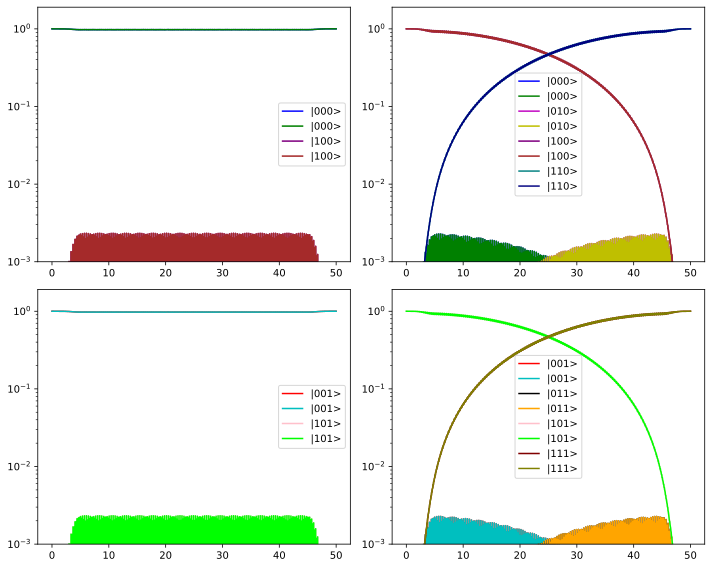

In [ ]:
temp_opt_freq_gen(H_totcx1, argscx1)

In [ ]:
U_act_comp = U_full2comp(U_act)
U_id_comp = U_full2comp(U_id)

print(np.abs(U_act_comp.full())**2)
print()
print(np.real(U_id_comp.full()))
print()
print(np.imag(U_id_comp.full()))

[[9.99995197e-01 6.31716262e-18 9.36038661e-09 1.11541873e-17
  1.30732055e-10 3.02475119e-16 2.06921482e-10 3.65747869e-18]
 [1.19824214e-17 9.99995156e-01 7.61039413e-18 9.72229070e-12
  5.48706988e-08 1.19796230e-10 5.45935505e-08 2.06764673e-10]
 [9.32845401e-09 1.06220216e-17 9.99993616e-01 5.81881625e-18
  1.98939506e-10 3.02660038e-17 1.38574018e-10 2.93720394e-16]
 [7.46402553e-18 1.93100358e-11 1.11816604e-17 9.99993290e-01
  5.60638989e-08 1.96625791e-10 5.56889030e-08 1.39502964e-10]
 [2.14796279e-10 5.50065485e-08 1.41817330e-10 5.59424403e-08
  1.17477741e-04 6.40066820e-18 9.99880889e-01 1.26517548e-17]
 [3.06965603e-16 1.90340392e-10 3.10988556e-17 1.45690202e-10
  1.09145709e-17 1.16178476e-04 6.05276694e-18 9.99880424e-01]
 [1.36294493e-10 5.47238562e-08 1.95009115e-10 5.55773649e-08
  9.99877257e-01 1.21898660e-17 1.13610837e-04 7.69537325e-18]
 [3.65490598e-18 1.36827020e-10 2.90849845e-16 1.96907045e-10
  5.65653109e-18 9.99878668e-01 1.09885274e-17 1.14517444e-04]]

 /var/folders/9c/bjvx9kmd7dj9q_54kfzvkj800000gn/T/ipykernel_15424/1974673736.py: 5

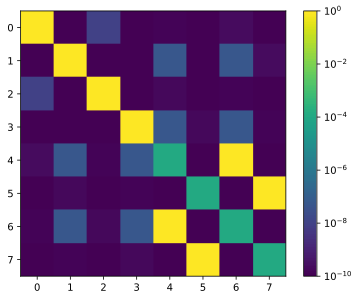

In [ ]:


# Generate sample data (replace with your actual data)
data = np.abs(U_act_comp.full())**2

# Create the colormap with the specified range and number of steps
cmap = plt.cm.get_cmap('viridis', 100)  # 100 steps in the colormap

# Create the 2D color plot with log scale and custom colormap
plt.imshow(data, cmap=cmap, norm=LogNorm(vmin=1e-10, vmax=1))

# Add colorbar to show the mapping between colors and values
plt.colorbar()

# Display the plot
plt.show()

 /var/folders/9c/bjvx9kmd7dj9q_54kfzvkj800000gn/T/ipykernel_15424/1636791507.py: 5

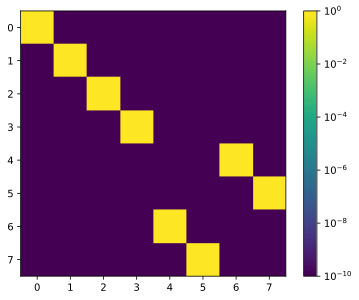

In [ ]:
# Generate sample data (replace with your actual data)
data1 = np.abs(U_id_comp.full())**2

# Create the colormap with the specified range and number of steps
cmap = plt.cm.get_cmap('viridis', 100)  # 100 steps in the colormap

# Create the 2D color plot with log scale and custom colormap
plt.imshow(data1, cmap=cmap, norm=LogNorm(vmin=1e-10, vmax=1))

# Add colorbar to show the mapping between colors and values
plt.colorbar()

# Display the plot
plt.show()

In [ ]:
element_indices = [(0,0),(1,1),(2,2),(3,3),(6,4),(7,5),(4,6),(5,7)]
s1 =0
for (i,j) in element_indices:
    print('Different error contributions', np.abs(U_act_comp.full()[i,j]), 'for ',i,j )

    
    s1 += np.abs(U_act_comp.full()[i,j])
print('================' )



op1 = qt.Qobj(np.abs(U_act_comp.full())) * qt.Qobj(np.abs(U_act_comp.full())).dag()

#print('fidelity =',(op1.tr()+ s1 ** 2)/72 )
op2 = qt.Qobj(np.abs(U_act_comp.full())) * qt.Qobj(np.abs(U_id_comp.full())).dag()
fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0

print('compare these two contributions:',(abs(op2.tr()))**2, s1 ** 2)
print('and the fidelities ',fidelity, (op1.tr()+ s1 ** 2)/72)

Different error contributions 0.9999975982711587 for  0 0
Different error contributions 0.9999975781434091 for  1 1
Different error contributions 0.9999968080419945 for  2 2
Different error contributions 0.9999966450563567 for  3 3
Different error contributions 0.9999386267365586 for  6 4
Different error contributions 0.9999393320968174 for  7 5
Different error contributions 0.9999404425734334 for  4 6
Different error contributions 0.9999402101095727 for  5 7
compare these two contributions: 63.995955920355996 63.99595592035591
and the fidelities  0.9999432314638184 0.9999432314638173


In [ ]:
for k in range(8):
    print(np.abs(op2.full()[k,k])) 

0.9999975982711592
0.9999975781434073
0.9999968080419932
0.9999966450563567
0.9999404425734336
0.9999402101095722
0.9999386267365593
0.9999393320968246


### Switching to Computational Subspace

In [ ]:
def U_full2comp(U_f):
    U8x8 = 1j*np.zeros([8,8])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    for mx in range(2):
                        for nx in range(2):
                            U8x8[4*dx+2*jx+kx,4*lx+2*mx+nx] = U_f.matrix_element(dressed_epairs[dx,jx,kx][1],dressed_epairs[lx,mx,nx][1])
    return qt.Qobj(U8x8)

U_act_comp = U_full2comp(U_act)
U_id_comp = U_full2comp(U_id)

np.set_printoptions(precision=1)

print(np.abs(U_act_comp.full()))
print()
print(np.real(U_id_comp.full()))
print()
print(np.imag(U_id_comp.full()))

op1 = qt.Qobj(np.abs(U_act_comp.full())) * qt.Qobj(np.abs(U_act_comp.full())).dag()
op2 = qt.Qobj(np.abs(U_act_comp.full())) * qt.Qobj(np.abs(U_id_comp.full())).dag()
fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0
print(fidelity)

[[1.0e+00 2.5e-09 9.7e-05 3.3e-09 1.1e-05 1.7e-08 1.4e-05 1.9e-09]
 [3.5e-09 1.0e+00 2.8e-09 3.1e-06 2.3e-04 1.1e-05 2.3e-04 1.4e-05]
 [9.7e-05 3.3e-09 1.0e+00 2.4e-09 1.4e-05 5.5e-09 1.2e-05 1.7e-08]
 [2.7e-09 4.4e-06 3.3e-09 1.0e+00 2.4e-04 1.4e-05 2.4e-04 1.2e-05]
 [1.5e-05 2.3e-04 1.2e-05 2.4e-04 1.1e-02 2.5e-09 1.0e+00 3.6e-09]
 [1.8e-08 1.4e-05 5.6e-09 1.2e-05 3.3e-09 1.1e-02 2.5e-09 1.0e+00]
 [1.2e-05 2.3e-04 1.4e-05 2.4e-04 1.0e+00 3.5e-09 1.1e-02 2.8e-09]
 [1.9e-09 1.2e-05 1.7e-08 1.4e-05 2.4e-09 1.0e+00 3.3e-09 1.1e-02]]

[[ 1.0e+00 -2.3e-17 -6.5e-16 -5.4e-19 -2.2e-16 -7.2e-19  5.3e-18  2.0e-18]
 [-2.3e-17  1.0e+00  7.6e-18 -3.0e-17  2.6e-14  8.4e-18 -7.9e-17 -7.2e-16]
 [-6.5e-16  7.1e-18  1.0e+00 -1.9e-16 -1.9e-16  2.5e-17 -1.5e-16  9.8e-17]
 [ 1.1e-19 -3.0e-17 -1.9e-16  1.0e+00 -2.0e-14  8.2e-16 -2.2e-14 -1.4e-16]
 [-2.2e-16  2.6e-14 -1.9e-16 -2.0e-14 -1.7e-17  6.3e-17  1.0e+00 -1.0e-15]
 [-7.2e-19  8.6e-18  2.5e-17  8.2e-16  6.3e-17 -4.8e-17 -5.8e-16  1.0e+00]
 [ 5.0e-18 -

### Analytical Solution

Single qubit rotations needed to correct the phase after the cross resonance gate is performed

In [ ]:
print(np.abs(U_id_comp.full()))

[[1.0e+00 3.0e-16 4.3e-15 5.4e-19 3.2e-16 7.2e-19 5.3e-18 2.2e-18]
 [3.0e-16 1.0e+00 4.9e-17 3.1e-17 4.3e-14 3.4e-17 8.1e-17 7.9e-16]
 [4.3e-15 4.9e-17 1.0e+00 1.2e-15 3.1e-16 4.5e-17 1.2e-15 1.2e-16]
 [1.1e-19 3.1e-17 1.2e-15 1.0e+00 2.0e-14 8.2e-16 2.2e-14 1.5e-16]
 [3.2e-16 4.3e-14 3.1e-16 2.0e-14 1.7e-17 6.3e-17 1.0e+00 1.7e-15]
 [7.2e-19 3.4e-17 4.5e-17 8.2e-16 6.3e-17 4.8e-17 5.8e-16 1.0e+00]
 [5.0e-18 8.1e-17 1.2e-15 2.2e-14 1.0e+00 5.8e-16 3.8e-15 6.3e-17]
 [2.2e-18 7.9e-16 1.2e-16 1.5e-16 1.7e-15 1.0e+00 6.4e-17 6.5e-13]]


In [ ]:
import sympy as sp

a = sp.Symbol('a')
b = sp.Symbol('b')
c = sp.Symbol('c')
d = sp.Symbol('d')
e = sp.Symbol('e')
f = sp.Symbol('f')
g = sp.Symbol('g')
h = sp.Symbol('h')

U_sym = sp.Matrix([[sp.exp(1j*a),0,0,0,0,0,0,0], [0,sp.exp(1j*b),0,0,0,0,0,0], [0,0,sp.exp(1j*c),0,0,0,0,0], [0,0,0,sp.exp(1j*d),0,0,0,0], [0,0,0,0,0,0, sp.exp(1j*e),0], [0,0,0,0,0,0,0,sp.exp(1j*f)], [0,0,0,0,sp.exp(1j*g),0,0,0], [0,0,0,0,0,sp.exp(1j*h),0,0]])
id_sym = sp.Matrix([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0]])

In [ ]:
U_sym

Matrix([
[exp(1.0*I*a),            0,            0,            0,            0,            0,            0,            0],
[           0, exp(1.0*I*b),            0,            0,            0,            0,            0,            0],
[           0,            0, exp(1.0*I*c),            0,            0,            0,            0,            0],
[           0,            0,            0, exp(1.0*I*d),            0,            0,            0,            0],
[           0,            0,            0,            0,            0,            0, exp(1.0*I*e),            0],
[           0,            0,            0,            0,            0,            0,            0, exp(1.0*I*f)],
[           0,            0,            0,            0, exp(1.0*I*g),            0,            0,            0],
[           0,            0,            0,            0,            0, exp(1.0*I*h),            0,            0]])

In [ ]:
r1, r2, r3, r4, r5, r6, r7, r8 = sp.symbols('r1 r2 r3 r4 r5 r6 r7 r8')
r9, r10, r11, r12, r13, r14, r15, r16 = sp.symbols('r9 r10 r11 r12 r13 r14 r15 r16')

r1_sym = sp.Matrix([[sp.exp(1j*r1),0,0,0,0,0,0,0], [0,sp.exp(1j*r2),0,0,0,0,0,0], [0,0,sp.exp(1j*r3),0,0,0,0,0], [0,0,0,sp.exp(1j*r4),0,0,0,0], [0,0,0,0,sp.exp(1j*r5),0,0,0], [0,0,0,0,0,sp.exp(1j*r6),0,0], [0,0,0,0,0,0,sp.exp(1j*r7),0], [0,0,0,0,0,0,0,sp.exp(1j*r8)]])
r2_sym = sp.Matrix([[sp.exp(1j*r9),0,0,0,0,0,0,0], [0,sp.exp(1j*r10),0,0,0,0,0,0], [0,0,sp.exp(1j*r11),0,0,0,0,0], [0,0,0,sp.exp(1j*r12),0,0,0,0], [0,0,0,0,sp.exp(1j*r13),0,0,0], [0,0,0,0,0,sp.exp(1j*r14),0,0], [0,0,0,0,0,0,sp.exp(1j*r15),0], [0,0,0,0,0,0,0,sp.exp(1j*r16)]])

In [ ]:
eq = sp.Eq(id_sym, r1_sym * U_sym* r2_sym)
sp.simplify(eq)

Eq(Matrix([
[1, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0]]), Matrix([
[exp(1.0*I*(a + r1 + r9)),                         0,                         0,                         0,                         0,                         0,                         0,                         0],
[                       0, exp(1.0*I*(b + r10 + r2)),                         0,                         0,                         0,                         0,                         0,                         0],
[                       0,                         0, exp(1.0*I*(c + r11 + r3)),                         0,                         0,                         0,                         0,                         0],
[                       0,                         0,                         0, exp(1.0*I*(d + r12 + r4)),           

In [ ]:
sp.solve([a+r1+r9, b+r10+r2, c+r11+r3, d+r12+r4, g+r13+r7, h+r14+r8, e+r15+r5, f+r16+r6], [r1,r2,r3,r4,r5,r6,r7,r8])

{r1: -a - r9,
 r2: -b - r10,
 r3: -c - r11,
 r4: -d - r12,
 r7: -g - r13,
 r8: -h - r14,
 r5: -e - r15,
 r6: -f - r16}

### Implementation Using Only R1 (R2 = I)

In [ ]:
Rot1 = np.diag([np.exp(-1j*np.angle(U_act_comp[0,0])), np.exp(-1j*np.angle(U_act_comp[1,1])), np.exp(-1j*np.angle(U_act_comp[2,2])), np.exp(-1j*np.angle(U_act_comp[3,3])),
                 np.exp(-1j*np.angle(U_act_comp[4,6])), np.exp(-1j*np.angle(U_act_comp[5,7])), np.exp(-1j*np.angle(U_act_comp[6,4])), np.exp(-1j*np.angle(U_act_comp[7,5]))])

U_act_comp_rot1 = qt.Qobj(Rot1 * U_act_comp)

op1 = U_act_comp_rot1.dag() * U_act_comp_rot1
op2 = U_act_comp_rot1 * U_id_comp.dag()
fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0

print(fidelity)

0.9999432314638165


### Ideal Fl2-TR CNOT Gate

Define and evaluate an optimized CX gate between the right Fluxonium (control) and the Transmon (target)

In [ ]:
eta2 = - (np.abs(n_Fl2_full.matrix_element(dressed_epairs[0,0,0][1], dressed_epairs[0,1,0][1])      
        /n_Tr_full.matrix_element(dressed_epairs[0,0,0][1], dressed_epairs[0,1,0][1])))

U_id2 = 0
U_id2 += dressed_epairs[0,0,0][1]*dressed_epairs[0,0,0][1].dag()
U_id2 += dressed_epairs[0,1,0][1]*dressed_epairs[0,1,0][1].dag()
U_id2 += dressed_epairs[0,1,1][1]*dressed_epairs[0,0,1][1].dag()
U_id2 += dressed_epairs[0,0,1][1]*dressed_epairs[0,1,1][1].dag()
U_id2 += dressed_epairs[1,0,0][1]*dressed_epairs[1,0,0][1].dag()
U_id2 += dressed_epairs[1,1,0][1]*dressed_epairs[1,1,0][1].dag()
U_id2 += dressed_epairs[1,1,1][1]*dressed_epairs[1,0,1][1].dag()
U_id2 += dressed_epairs[1,0,1][1]*dressed_epairs[1,1,1][1].dag()

def abs_fidelity_CX2(params):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl2_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = gate(H_tot, args)
    U_act_abs = qt.Qobj(np.abs(U_act.full()))
    U_id2_abs = qt.Qobj(np.abs(U_id2.full()))

    op1 = U_act_abs.dag() * U_act_abs
    op2 = U_act_abs * U_id2_abs.dag()
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0
    return -fidelity

In [ ]:
initial_guess = [1, eta2, 1]
result = opt.minimize(abs_fidelity_CX2, initial_guess, method='Nelder-Mead', options = {'fatol' : 0.00001, 'xatol': 0.00001})
max_fidelity2 = -result.fun

optimal_params2 = result.x
optimal_alpha2, optimal_eta2, optimal_detuning2 = optimal_params2
print(f"Optimal eta: {optimal_eta2}")
print(f"Optimal alpha: {optimal_alpha2}")
print(f"Optimal detuning: {optimal_detuning2}")
print(f"Maximized fidelity: {max_fidelity2}")

Optimal eta: 0.0017939591361283915
Optimal alpha: 5.154229594351202
Optimal detuning: 1.000065962042811
Maximized fidelity: 0.9999361943338607


In [ ]:
opt_eta2 = optimal_eta2
opt_alpha2 = optimal_alpha2
opt_detuning2 = optimal_detuning2

H_totcx2 = [H_full, [opt_alpha2 * (n_Fl2_full + opt_eta2 * n_Tr_full), time_dep]]
argscx2 = {'t_g': t_g, 'w_d' : (dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])*opt_detuning2, 't_r': t_r}

U_act_comp2 = U_full2comp(gate(H_totcx2, argscx2))
U_id2_comp = U_full2comp(U_id2)

np.set_printoptions(precision=1)
print(np.real(U_id2_comp.full()))

[[ 1.0e+00 -2.8e-17 -6.4e-16  1.7e-18 -2.3e-16 -6.8e-19  6.3e-18  4.2e-17]
 [-2.8e-17  5.1e-18 -2.5e-16  1.0e+00 -2.6e-14 -8.9e-17 -2.0e-14 -6.3e-16]
 [-6.4e-16 -2.5e-16  1.0e+00 -1.2e-16 -5.5e-17  5.7e-17 -1.3e-16  9.7e-17]
 [ 1.7e-18  1.0e+00 -1.2e-16 -6.4e-17 -7.9e-17  9.2e-16 -2.2e-14 -8.6e-17]
 [-2.3e-16 -2.6e-14 -5.4e-17 -7.9e-17  1.0e+00 -3.8e-17 -6.8e-17 -2.6e-16]
 [-6.8e-19 -8.9e-17  5.7e-17  9.2e-16 -3.8e-17 -4.8e-17 -5.1e-16  1.0e+00]
 [ 6.6e-18 -2.0e-14 -1.3e-16 -2.2e-14 -6.8e-17 -5.1e-16  1.0e+00 -2.1e-15]
 [ 4.2e-17 -6.3e-16  9.7e-17 -8.7e-17 -2.6e-16  1.0e+00 -2.1e-15 -6.5e-13]]


### Direct Phase Correction

In [ ]:
Rot1 = np.diag([np.exp(-1j*np.angle(U_act_comp2[0,0])), np.exp(-1j*np.angle(U_act_comp2[1,3])), np.exp(-1j*np.angle(U_act_comp2[2,2])), np.exp(-1j*np.angle(U_act_comp2[3,1])),
                 np.exp(-1j*np.angle(U_act_comp2[4,4])), np.exp(-1j*np.angle(U_act_comp2[5,7])), np.exp(-1j*np.angle(U_act_comp2[6,6])), np.exp(-1j*np.angle(U_act_comp2[7,5]))])

U_act_comp_rot2 = qt.Qobj(Rot1 * U_act_comp2)

op1 = U_act_comp_rot2.dag() * U_act_comp_rot2
op2 = U_act_comp_rot2 * U_id2_comp.dag()
fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0

print(fidelity)

0.9999371474409955


### CX Gate Between Fl1 (control) and Fl2 (target)

This section uses the previously optimized Fl-Tr CX gates along with Hadamard gates to perform a CX gate between the fluxoniums when the transmon is initialized to $\ket{1}$.
$$CX_{13} = CX_{12} \cdot (I \otimes H \otimes H) \cdot CX_{32} \cdot (I \otimes H \otimes H) \cdot CX_{12}$$

In [ ]:

#Assuming Transmon is Always in State 1
def U_8x8to4x4(U_f):
    U_f = qt.Qobj(U_f)
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[dx*2+jx,2*kx+lx] = U_f.matrix_element(qt.tensor(qt.basis(2,np.abs(1-dx)),qt.basis(2,1),qt.basis(2,np.abs(1-jx))), qt.tensor(qt.basis(2,np.abs(1-kx)),qt.basis(2,1),qt.basis(2,np.abs(1-lx))))
    return U4x4

In [ ]:
SingleHadamard = qt.qip.operations.hadamard_transform()
Had = qt.Qobj(qt.tensor(qt.qeye(2), SingleHadamard, SingleHadamard).full())

CXIdeal = qt.Qobj(qt.qip.operations.cnot().full())
U_CX = U_8x8to4x4(U_act_comp_rot1 * Had * U_act_comp_rot2 * Had * U_act_comp_rot1)

print("Simulated Gate")
print(np.abs(U_CX).round(0))
print()
U_CX = qt.Qobj(U_CX)

print("Ideal Gate")
print(np.abs(CXIdeal.full()).round(0))

op1 = U_CX.dag() * U_CX
op2 = U_CX * CXIdeal.dag()
fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
print(fidelity)

Simulated Gate
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

Ideal Gate
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
0.9998456887590134


### Parity Check With Sequential CX Gates

This section demonstrates a parity check using the previously optimized individual CX gates
$$U_{PC} = CX_{12} \cdot CX_{32}$$

In [ ]:

U_idPC_comp = U_id_comp*U_id2_comp
U_Slow = U_act_comp_rot2 * U_act_comp_rot1

op1 = U_Slow.dag() * U_Slow
op2 = U_Slow * U_idPC_comp.dag()
fidelity = (op1.tr() + (abs(op2.tr()))**2) / 72.0
print(fidelity)

0.9998301764521658


### Two Drive Simultaneous Parity Check

Simultaneous cross resonance gates between each Fluxonium and the middle Transmon perform a parity check

In [ ]:
b_vecs = []
for i1 in range(2):
    for i2 in range(2):
        for i3 in range(2):
            b_vecs.append(qt.tensor(qt.basis(2,i1), qt.basis(2,i2), qt.basis(2,i3)))


def time_dep1(t, args):
    w_d1 = args['w_d1']
    return 2 * np.cos(w_d1*t) * envelop_function(t,args['t_g'], args['t_r'])

def time_dep2(t, args):
    w_d2 = args['w_d2']
    return -2 * np.cos(w_d2*t) * envelop_function(t,args['t_g'], args['t_r'])

def PC_fidelity(params):
    alpha1, alpha2, detuning1, detuning2, eta1, eta2 = params
    w_d1 = (dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0])*detuning1
    w_d2 = (dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])*detuning2
    H_tot = [H_full, [alpha1 * (n_Fl1_full + eta1 * n_Tr_full), time_dep1], [alpha2 * (n_Fl2_full + eta2 * n_Tr_full), time_dep2]]
    
    args = {'t_g': t_g, 'w_d1' : w_d1, 'w_d2' : w_d2, 't_r': t_r}
    
    U_act = gate(H_tot, args)
    U_act_comp = U_full2comp(U_act)
    
    U_even = 1j*np.zeros([2,2])
    for n1, i1 in enumerate([0,5]):
        for n2, i2 in enumerate([0,5]):
            U_even[n1,n2] = U_act_comp.matrix_element(b_vecs[i1],b_vecs[i2])
    U_even = qt.Qobj(np.abs(U_even))

    U_odd = 1j*np.zeros([2,2])
    for n1, i1 in enumerate([3,6]):
        for n2, i2 in enumerate([1,4]):
            U_odd[n1,n2] = U_act_comp.matrix_element(b_vecs[i1],b_vecs[i2])
    U_odd = qt.Qobj(np.abs(U_odd))

    return -(qt.average_gate_fidelity(U_even) + qt.average_gate_fidelity(U_odd))/2

In [ ]:
initial_guess = [optimal_alpha, optimal_alpha2, optimal_detuning, optimal_detuning2, optimal_eta, optimal_eta2]
result = opt.minimize(PC_fidelity, initial_guess, method='Nelder-Mead', options = {'fatol' : 0.00001, 'xatol': 0.0001})
max_fidelity = -result.fun

optimal_params = result.x
max_fidelity = -result.fun
optimal_alpha1, optimal_alpha2, optimal_detuning1, optimal_detuning2, optimal_eta1, optimal_eta2 = optimal_params

print(f"Optimal alpha: {optimal_alpha1}")
print(f"Optimal alpha: {optimal_alpha2}")
print(f"Optimal detuning: {optimal_detuning1}")
print(f"Optimal detuning: {optimal_detuning2}")
print(f"Optimal eta: {optimal_eta1}")
print(f"Optimal eta: {optimal_eta2}")
print(f"Maximized fidelity: {max_fidelity}")

Optimal alpha: 5.092307854161307
Optimal alpha: 5.152935307594511
Optimal detuning: 1.0000349446762715
Optimal detuning: 1.0000365732538468
Optimal eta: 0.001806895570197896
Optimal eta: 0.0017977028834013442
Maximized fidelity: 0.9999933302309065


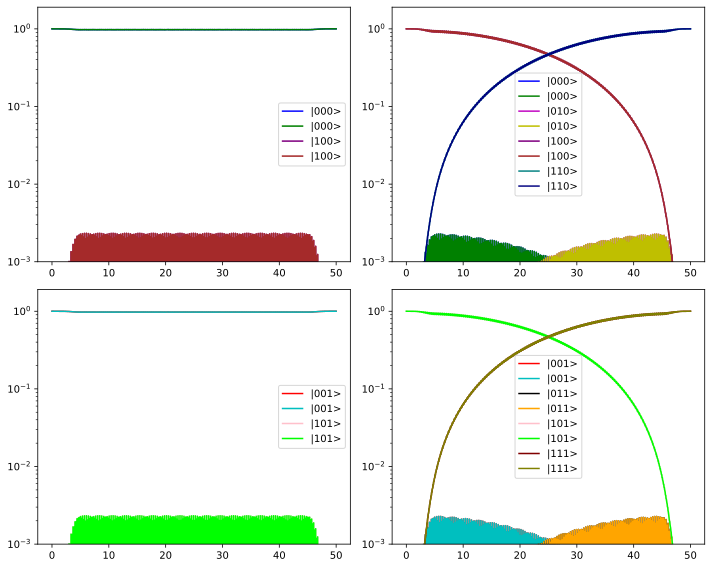

In [ ]:

w_d1 = (dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0])*optimal_detuning1
w_d2 = (dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])*optimal_detuning2
H_tot = [H_full, [optimal_alpha1 * (n_Fl1_full + optimal_eta1 * n_Tr_full), time_dep1], [optimal_alpha2 * (n_Fl2_full + eta2 * n_Tr_full), time_dep2]]
args = {'t_g': t_g, 'w_d1' : w_d1, 'w_d2' : w_d2, 't_r': t_r}
temp_opt_freq_gen(H_totcx1, argscx1)

In [ ]:
U_idPC_comp

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

### One Drive Parity Check

Since the frequency of the two drives needed in the previous section is close, a single drive with frequency between $\omega_{d_1}$ and $\omega_{d_2}$ acting on all three qubits is sufficient for a parity check of reasonably high fidelity

In [ ]:
def PC_1D_fidelity(params):

    alpha, eta, beta, detuning = params
    w_d = ((dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0] + dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])/2)*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full + beta * n_Fl2_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = gate(H_tot, args)
    U_act_comp = U_full2comp(U_act)
    
    U_even = 1j*np.zeros([2,2])
    for n1, i1 in enumerate([0,5]):
        for n2, i2 in enumerate([0,5]):
            U_even[n1,n2] = U_act_comp.matrix_element(b_vecs[i1],b_vecs[i2])
    U_even = qt.Qobj(np.abs(U_even))

    U_odd = 1j*np.zeros([2,2])
    for n1, i1 in enumerate([3,6]):
        for n2, i2 in enumerate([1,4]):
            U_odd[n1,n2] = U_act_comp.matrix_element(b_vecs[i1],b_vecs[i2])
    U_odd = qt.Qobj(np.abs(U_odd))

    return -(qt.average_gate_fidelity(U_even) + qt.average_gate_fidelity(U_odd))/2

    

In [ ]:
initial_guess = [optimal_alpha1, 0.002599808666231697, -1, 1]
result = opt.minimize(PC_1D_fidelity, initial_guess, method='Nelder-Mead', options = {'fatol' : 0.00001, 'xatol': 0.00001})

optimal_params = result.x
fidelity = -result.fun
optimal_alpha, optimal_eta, optimal_beta, optimal_detuning = optimal_params

print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal eta: {optimal_eta}")
print(f"Optimal beta: {optimal_beta}")
print(f"Optimal detuning: {optimal_detuning}")
print(f"Optimal fidelity: {fidelity}")

Optimal alpha: 5.09229405736369
Optimal eta: -1.2219526459504921e-05
Optimal beta: -1.0118919706293998
Optimal detuning: 1.0000357283667014
Optimal fidelity: 0.9999933242924333


In [ ]:
def PC_1D_fidelity_debug(params):

    alpha, eta, beta = params
    w_d = ((dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0] + dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])/2)*0.99999
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full + beta * n_Fl2_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = gate(H_tot, args)
    
    U_even = 1j*np.zeros([2,2])
    U_even[0,0] = U_act.matrix_element(dressed_epairs[1,0,1][1],dressed_epairs[1,0,1][1])
    U_even[0,1] = U_act.matrix_element(dressed_epairs[1,0,1][1],dressed_epairs[1,1,1][1])
    U_even[1,0] = U_act.matrix_element(dressed_epairs[0,0,0][1],dressed_epairs[0,1,0][1])
    U_even[1,1] = U_act.matrix_element(dressed_epairs[0,0,0][1],dressed_epairs[0,0,0][1])
    U_even = qt.Qobj(np.abs(U_even))

    U_odd = 1j*np.zeros([2,2])
    U_odd[0,0] = U_act.matrix_element(dressed_epairs[1,0,0][1],dressed_epairs[1,1,0][1])
    U_odd[0,1] = U_act.matrix_element(dressed_epairs[1,0,0][1],dressed_epairs[1,0,0][1])
    U_odd[1,0] = U_act.matrix_element(dressed_epairs[0,0,1][1],dressed_epairs[0,0,1][1])
    U_odd[1,1] = U_act.matrix_element(dressed_epairs[0,0,1][1],dressed_epairs[0,1,1][1])
    U_odd = qt.Qobj(np.abs(U_odd))

    print(U_even)
    print(qt.average_gate_fidelity(U_even))
    print(U_odd)
    print(qt.average_gate_fidelity(U_odd))

    return

In [ ]:
PC_1D_fidelity_debug([optimal_alpha, optimal_eta, optimal_beta])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[1.0e+00 4.8e-05]
 [3.5e-05 1.0e+00]]
0.9999951088346802
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[1. 0.]
 [0. 1.]]
0.9996135202852807


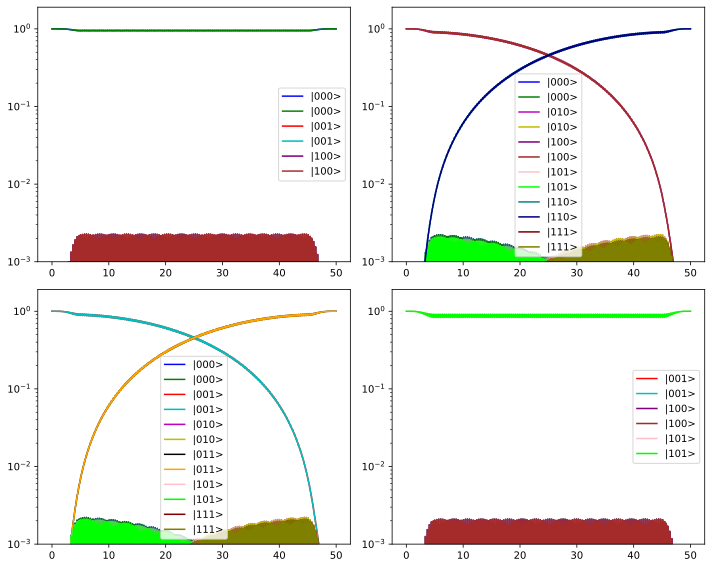

In [ ]:
H_tot = [H_full, [optimal_alpha * (n_Fl1_full + optimal_eta * n_Tr_full + optimal_beta * n_Fl2_full), time_dep]]
w_d = (dressed_epairs[1, 1, 0][0] - dressed_epairs[1, 0, 0][0] + dressed_epairs[0, 1, 1][0] - dressed_epairs[0, 0, 1][0])/2
args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

temp_opt_freq_gen(H_tot, args)